In [1]:
# Imports for Dataset class
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Imports for dataloader
from torch.utils.data import DataLoader

# Imports for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Imports for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {}  # Mapping from original labels to continuous range

        # Collect all image paths and labels
        for filename in os.listdir(root_dir):
            if filename.startswith('color_'):
                # Extract label from filename
                parts = filename.split('_')
                label = int(parts[1])  # Assuming the label is the second part of the filename
                self.image_paths.append(os.path.join(root_dir, filename))
                self.labels.append(label)

        # Create a continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure image is in grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


root_dir = 'dataset5_50x50_split/'
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range for grayscale
])

# Create dataset instances
train_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'train'), transform=transform)
val_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'val'), transform=transform)
test_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'test'), transform=transform)


In [3]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Class for CNN. Can be updated to include multi-headed input
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Function to infer number of classes
def get_num_classes(dataset):
    """
    Get the number of unique classes in the dataset.

    Args:
        dataset (Dataset): The dataset to analyze.

    Returns:
        int: The number of unique classes.
    """
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [7]:
# Initialize the model, loss function, and optimizer
num_classes = get_num_classes(train_dataset)
model = SimpleCNN(num_classes=num_classes)
print("Model initialized")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Optimizer initialized")

# Initialize lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training loop with tqdm progress bar
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in train_loader_tqdm:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {train_accuracy}%")

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")

print("Training complete")

Model initialized
Optimizer initialized


Epoch 1/10: 100%|████████████| 1439/1439 [01:29<00:00, 16.14batch/s, loss=0.504]


Epoch 1, Loss: 0.5035092238805375, Accuracy: 84.93082252774701%
Validation Loss: 0.18505289963172283, Validation Accuracy: 94.39489154672613%


Epoch 2/10: 100%|███████████| 1439/1439 [01:30<00:00, 15.96batch/s, loss=0.0823]


Epoch 2, Loss: 0.08233660093542315, Accuracy: 97.41317521339676%
Validation Loss: 0.10632187562458169, Validation Accuracy: 96.66531522400162%


Epoch 3/10: 100%|███████████| 1439/1439 [01:31<00:00, 15.74batch/s, loss=0.0368]


Epoch 3, Loss: 0.03680554780955546, Accuracy: 98.8336482700202%
Validation Loss: 0.09446190977710206, Validation Accuracy: 97.35455098317453%


Epoch 4/10: 100%|███████████| 1439/1439 [01:34<00:00, 15.24batch/s, loss=0.0294]


Epoch 4, Loss: 0.02938049451198325, Accuracy: 99.03781412219543%
Validation Loss: 0.08627334015551671, Validation Accuracy: 97.80052706263936%


Epoch 5/10: 100%|███████████| 1439/1439 [01:34<00:00, 15.28batch/s, loss=0.0225]


Epoch 5, Loss: 0.02254815078105304, Accuracy: 99.26152776872787%
Validation Loss: 0.12136244425979785, Validation Accuracy: 97.29373606324752%


Epoch 6/10: 100%|███████████| 1439/1439 [01:34<00:00, 15.21batch/s, loss=0.0194]


Epoch 6, Loss: 0.019356740469328233, Accuracy: 99.32885906040268%
Validation Loss: 0.09237189460249795, Validation Accuracy: 97.71944050273667%


Epoch 7/10: 100%|███████████| 1439/1439 [01:37<00:00, 14.71batch/s, loss=0.0166]


Epoch 7, Loss: 0.016620767869390003, Accuracy: 99.45917768945071%
Validation Loss: 0.09735567494485725, Validation Accuracy: 97.83093452260287%


Epoch 8/10: 100%|███████████| 1439/1439 [01:33<00:00, 15.39batch/s, loss=0.0151]


Epoch 8, Loss: 0.015064644191652515, Accuracy: 99.4961013010143%
Validation Loss: 0.10012024017440474, Validation Accuracy: 97.8917494425299%


Epoch 9/10: 100%|███████████| 1439/1439 [01:35<00:00, 15.13batch/s, loss=0.0134]


Epoch 9, Loss: 0.01338413668040581, Accuracy: 99.53954084403033%
Validation Loss: 0.10416640247502097, Validation Accuracy: 97.98297182242044%


Epoch 10/10: 100%|██████████| 1439/1439 [01:35<00:00, 15.10batch/s, loss=0.0108]


Epoch 10, Loss: 0.010796240439880759, Accuracy: 99.63727981581634%
Validation Loss: 0.09442642243335185, Validation Accuracy: 98.13500912223799%
Training complete


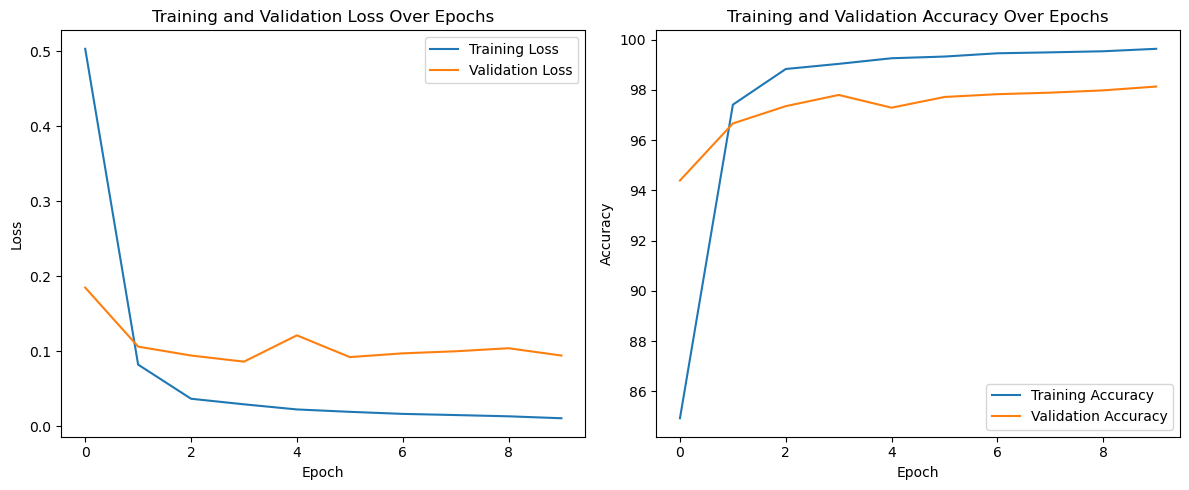

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

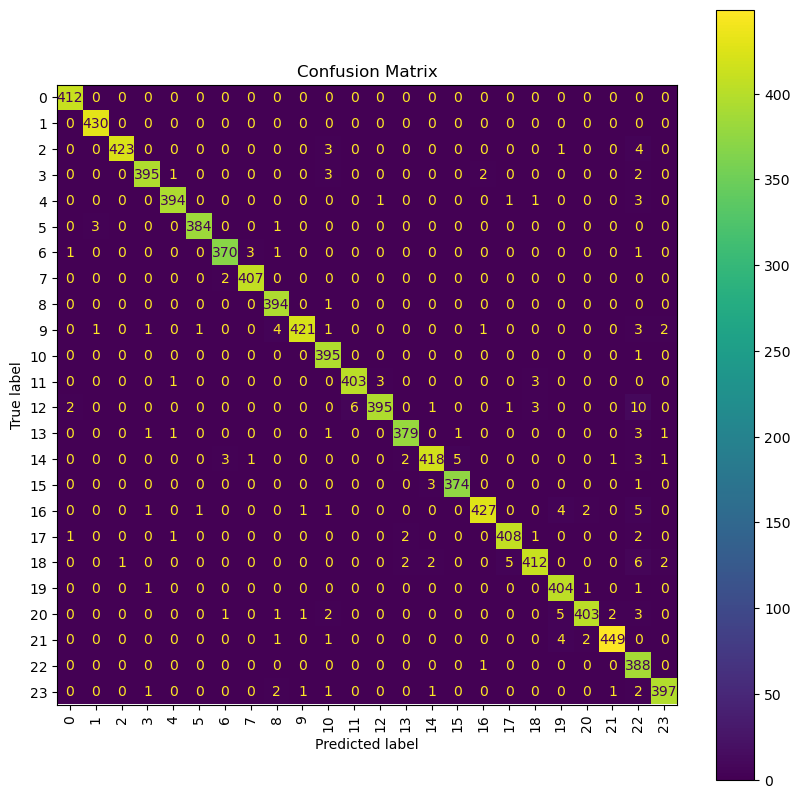

In [9]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()